In [1]:
from erlyx.environment import BaseEnvironment, Episode, GymEnvironment
from erlyx import types

import numpy as np

import cv2

In [2]:
from erlyx.policies import PytorchPolicy, FeedForwardNetworkPolicy
from erlyx.agents import EpsilonGreedyAgent
from erlyx.datasets import DequeDataset
from erlyx.algorithms.ddqn import DoubleDeepQLearner
from erlyx.callbacks import *

import erlyx

import torch

In [3]:
from collections import deque

In [4]:
class DiscreteRewradGymEnvironment(GymEnvironment):
    HISTORY_LEN = 4
    def __init__(self, env_name, simplified_reward=True):
        super(DiscreteRewradGymEnvironment, self).__init__(env_name)
        self._observation_buffer = deque(maxlen=self.HISTORY_LEN)
        self._simplified_reward = simplified_reward
        
    def new_episode(self) -> (Episode, types.ObservationType):
        observation = self.gym_env.reset()
        for _ in range(self.HISTORY_LEN):
            self._observation_buffer.append(observation)
        return self, self._get_observation()
    
    def step(self, action):
        reward = 0
        for _ in range(1):
            observation, _reward, done, = self._step(action)
            reward += _reward
        self._observation_buffer.append(observation)
        return types.EpisodeStatus(self._get_observation(), reward, done)
    
    def _step(self, action: types.ActionType) -> types.EpisodeStatus:
        observation, reward, done, _ = self.gym_env.step(action)
        if self._simplified_reward:
            if reward > 0:
                reward = 1
            elif reward < 0:
                reward = -1
            else:
                reward = 0
        return types.EpisodeStatus(observation, reward, done)
    
    def _get_observation(self):
        return np.array([self.downsample(o) for o in self._observation_buffer])

    def downsample(self, img):
        return img[::2, ::2, :]

In [5]:
class ConvNetwork(torch.nn.Module):
    def __init__(self):
        print('original')
        super(ConvNetwork, self).__init__()
        self._conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1),
            torch.nn.ReLU(),
        )
        self._linear = torch.nn.Sequential(
            torch.nn.Linear(64*70, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,  num_actions)
        )
                
    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        output = self._conv1(x)
        output = output.view(x.shape[0], -1)
        output = self._linear(output)
        return output

In [6]:
class CNNPolicy(PytorchPolicy):
    def __init__(self):
        self._model = ConvNetwork()
        
    @property
    def model(self):
        return self._model
    
    def process_observation(self, observation):
        r, g, b = observation[:, :, :, 0], observation[:, :, :, 1], observation[:, :, :, 2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b     # extract luminance
        tensor = torch.Tensor(gray/128. - 1.)/0.35 # divided by 0.35 because of standard deviation
        return tensor
        
    def get_distribution(self, state):
        with torch.no_grad():
            self.model.eval()
            q_values = self.model(self.process_observation(state))
            distribution = torch.nn.functional.softmax(q_values, dim=1)
        return distribution.data.cpu().numpy().reshape(-1)
    
    def num_actions(self) -> int:
        return num_actions


In [8]:
#cp = torch.load('best_checkpoint.sd')

In [9]:
num_actions = 18
policy = CNNPolicy()
#policy.model.load_state_dict(cp['model'])
dataset = DequeDataset(100_000)
agent = EpsilonGreedyAgent(policy, 0.)
learner = DoubleDeepQLearner(32, policy, 1e-4/4, 10_000, loss_func=torch.nn.SmoothL1Loss())
#learner.optimizer.load_state_dict(cp['optimizer'])

original


In [10]:
class CheckPointer(BaseCallback):
    def __init__(self, agent, environment, learner):
        self._agent = agent
        self._environment = environment
        self._learner = learner
        self._rewards = []
        self._counter = 0
        self._best_mean = -float('inf')
        
    def on_episode_end(self):
        self._counter += 1
        if self._counter % 15 == 0:
            reward_recorder = RewardRecorder()
            original_epsilon = self._agent.epsilon
            self._agent.epsilon = 0.05
            erlyx.run_episodes(
                self._environment, 
                self._agent, 
                5, 
                [reward_recorder], 
                use_tqdm=False
            )
            self._agent.epsilon = original_epsilon
            self._rewards.append(reward_recorder.rewards)
            new_mean = np.mean(reward_recorder.rewards)
            print(f'[Evaluation] mean: {new_mean}, rewards: {reward_recorder.rewards}')
            self._checkpoint('latest_checkpoint.sd')
            if new_mean > self._best_mean:
                print('new best wachin!')
                self._best_mean = new_mean
                self._checkpoint('best_checkpoint.sd')
    
    def _checkpoint(self, path):
        state = {
            'model': self._agent.policy.model.state_dict(), 
            'optimizer': self._learner.optimizer.state_dict()
        }
        torch.save(state, path)

In [11]:
class QValueTracker(BaseCallback):
    def __init__(self, policy, initial_state = None):
        self._policy = policy
        self.record = []
        self.initial_state = initial_state

    def on_episode_begin(self, initial_observation):
        if self.initial_state is None:
            self.initial_state = self._policy.process_observation(initial_observation)

    def on_step_end(self, action, observation, reward, done):
        with torch.no_grad():
            self._policy.model.eval()
            self.record.append(self._policy.model(self.initial_state))
            
    def plot(self, action):
        plt.plot(np.asarray(list(map(lambda x: x.data.cpu().numpy()[0], self.record)))[:, action])

In [14]:
train_callbacks = [
    TransitionRecorder(dataset), 
    OnlineUpdater(learner, dataset, 100_000, 1),
    LinearEpsilonDecay(agent, 1., 0.1, 1e-06),
    RewardRecorder(),
    QValueTracker(policy, initial_state=None),
    CheckPointer(agent, DiscreteRewradGymEnvironment('Seaquest-v0', simplified_reward=False), learner)
]

In [15]:
erlyx.run_steps(DiscreteRewradGymEnvironment('Seaquest-v0'), agent, 7_000_000, train_callbacks)

[Evaluation] mean: 1176.0, rewards: [1600.0, 1160.0, 1180.0, 980.0, 960.0]
new best wachin!
[Evaluation] mean: 1344.0, rewards: [1460.0, 1660.0, 1340.0, 1040.0, 1220.0]
new best wachin!
[Evaluation] mean: 1480.0, rewards: [1380.0, 1060.0, 1580.0, 1480.0, 1900.0]
new best wachin!
[Evaluation] mean: 748.0, rewards: [200.0, 960.0, 640.0, 960.0, 980.0]
[Evaluation] mean: 844.0, rewards: [920.0, 1260.0, 520.0, 820.0, 700.0]
[Evaluation] mean: 1044.0, rewards: [920.0, 500.0, 960.0, 1540.0, 1300.0]
[Evaluation] mean: 1232.0, rewards: [1580.0, 1360.0, 620.0, 1180.0, 1420.0]
[Evaluation] mean: 1104.0, rewards: [1200.0, 920.0, 1260.0, 1260.0, 880.0]
[Evaluation] mean: 1140.0, rewards: [1440.0, 1540.0, 640.0, 1340.0, 740.0]
[Evaluation] mean: 1424.0, rewards: [1440.0, 1040.0, 1200.0, 1560.0, 1880.0]
[Evaluation] mean: 960.0, rewards: [880.0, 680.0, 1600.0, 720.0, 920.0]
[Evaluation] mean: 1052.0, rewards: [1260.0, 1420.0, 1040.0, 440.0, 1100.0]
[Evaluation] mean: 1008.0, rewards: [880.0, 520.0, 1

KeyboardInterrupt: 

In [5]:
env = DiscreteRewradGymEnvironment('Seaquest-v0')

/home/schouhy/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
ep, ob = env.new_episode()

In [10]:
env = DiscreteRewradGymEnvironment('Seaquest-v0', simplified_reward=False)
erlyx.run_episodes(env, agent, 1, [GymRenderer(env, 50)])

In [16]:
import matplotlib.pyplot as plt

In [17]:
import pandas as pd

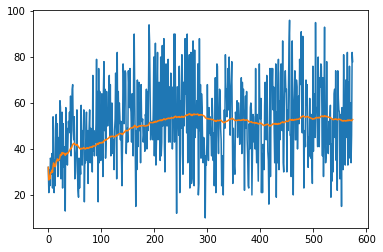

In [18]:
train_callbacks[-3].plot_rewards()
pd.Series(train_callbacks[-3].rewards).ewm(alpha=0.01).mean().plot()

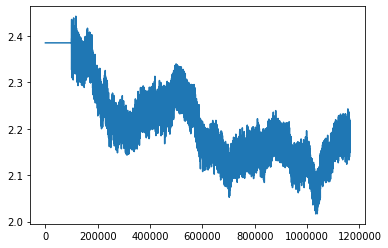

In [19]:
train_callbacks[-2].plot(0)

In [31]:
len(dataset._memory)

100000

In [39]:
train_callbacks

[Logger,
 TransitionRecorder,
 OnlineUpdater,
 LinearEpsilonDecay,
 RewardRecorder,
 AgentEvaluator,
 QValueTracker]

In [69]:
train_callbacks[-1].record[0].tolist()[0]

[-0.036834992468357086,
 0.019324684515595436,
 -0.04291766136884689,
 0.0739765614271164,
 -0.004521162714809179,
 -0.033491529524326324,
 -0.06971462070941925,
 -0.00527682900428772,
 0.03426133468747139,
 -0.01532486081123352,
 0.09612374752759933,
 0.031843289732933044,
 -0.03323833644390106,
 0.10109052062034607,
 -0.007529418915510178,
 -0.034887779504060745,
 0.07131735980510712,
 0.029284292832016945]

In [ ]:
sasa = list(map(lambda x: x.tolist()[0], train_callbacks[-1].record))

In [71]:
sasa[

[[-0.036834992468357086,
  0.019324684515595436,
  -0.04291766136884689,
  0.0739765614271164,
  -0.004521162714809179,
  -0.033491529524326324,
  -0.06971462070941925,
  -0.00527682900428772,
  0.03426133468747139,
  -0.01532486081123352,
  0.09612374752759933,
  0.031843289732933044,
  -0.03323833644390106,
  0.10109052062034607,
  -0.007529418915510178,
  -0.034887779504060745,
  0.07131735980510712,
  0.029284292832016945]]

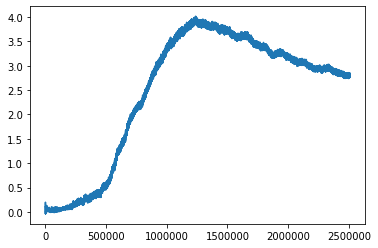

In [66]:
pd.Series(sasa).plot()